<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs" data-toc-modified-id="Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs-1">Analysis of full-length PacBio sequencing of influenza mRNAs</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span><ul class="toc-item"><li><span><a href="#Import-Python-modules" data-toc-modified-id="Import-Python-modules-1.1.1">Import Python modules</a></span></li><li><span><a href="#Define-/-create-directories" data-toc-modified-id="Define-/-create-directories-1.1.2">Define / create directories</a></span></li><li><span><a href="#How-many-CPUs-to-use" data-toc-modified-id="How-many-CPUs-to-use-1.1.3">How many CPUs to use</a></span></li></ul></li><li><span><a href="#Build-CCS's-from-PacBio-data" data-toc-modified-id="Build-CCS's-from-PacBio-data-1.2">Build CCS's from PacBio data</a></span><ul class="toc-item"><li><span><a href="#Get-subreads-files-for-each-sequencing-run" data-toc-modified-id="Get-subreads-files-for-each-sequencing-run-1.2.1">Get subreads files for each sequencing run</a></span></li><li><span><a href="#Run-ccs" data-toc-modified-id="Run-ccs-1.2.2">Run <code>ccs</code></a></span></li></ul></li><li><span><a href="#Process-CCS's" data-toc-modified-id="Process-CCS's-1.3">Process CCS's</a></span><ul class="toc-item"><li><span><a href="#Features-of-barcoded-CCSs" data-toc-modified-id="Features-of-barcoded-CCSs-1.3.1">Features of barcoded CCSs</a></span></li><li><span><a href="#Flu-mRNA-alignment-targets" data-toc-modified-id="Flu-mRNA-alignment-targets-1.3.2">Flu mRNA alignment targets</a></span></li><li><span><a href="#Match-and-align-barcoded-CCSs" data-toc-modified-id="Match-and-align-barcoded-CCSs-1.3.3">Match and align barcoded CCSs</a></span></li><li><span><a href="#Examine-unmatched-CCSs" data-toc-modified-id="Examine-unmatched-CCSs-1.3.4">Examine unmatched CCSs</a></span></li></ul></li><li><span><a href="#Now-align-to-flu-genes" data-toc-modified-id="Now-align-to-flu-genes-1.4">Now align to flu genes</a></span><ul class="toc-item"><li><span><a href="#Specify-target-flu-sequences-to-which-we-align" data-toc-modified-id="Specify-target-flu-sequences-to-which-we-align-1.4.1">Specify target flu sequences to which we align</a></span></li><li><span><a href="#Perform-the-alignments" data-toc-modified-id="Perform-the-alignments-1.4.2">Perform the alignments</a></span></li></ul></li></ul></li></ul></div>

# Analysis of full-length PacBio sequencing of influenza mRNAs
The material from the 10X libraries for the *IFN_enriched* sample was enriched for viral mRNAs by semi-specific PCR, and then sequenced by PacBio.
Here we analyze those data.

## Set up for analysis
First, we do some things to set up the parameters of the analysis.

### Import Python modules
We import the Python modules used.

Note we use some functions from [dms_tools2](https://jbloomlab.github.io/dms_tools2/).

We import [plotnine](https://plotnine.readthedocs.io/en/latest/) for plotting using a ggplot2-like syntax.

In [1]:
import os
import glob
import subprocess
import shutil
import multiprocessing
import warnings
import collections
warnings.simplefilter('ignore')

import pandas
from IPython.display import display, HTML
import Bio.SeqIO

import dms_tools2
print("Using dms_tools2 version {0}".format(dms_tools2.__version__))
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY

# import plotnine for plotting
from plotnine import *
_ = theme_set(theme_bw(base_size=12))

Using dms_tools2 version 2.3.dev0


### Define / create directories
We define the names of key directories for input and output, and create these directories if needed:

In [2]:
# top results directory
resultsdir = './results/'

# directory for PacBio results
pacbioresultsdir = os.path.join(resultsdir, 'pacbio')
os.makedirs(pacbioresultsdir, exist_ok=True)

### How many CPUs to use
Specify max number to use:

In [3]:
max_cpus = 14 # max number of CPUs to use
ncpus = max(multiprocessing.cpu_count(), max_cpus)

## Build CCS's from PacBio data
First, we build the circular consensus sequences (CCSs).

### Get subreads files for each sequencing run
We have multiple sequencing runs:
  - A run from June-8-2017 done at the UW PacBio core. This run used a PacBio RSII machine.
  - A run from December-7-2017 done at the Fred Hutch Genomics core. This run used a PacBio Sequel machine.
  
Note that the material sequenced for these two runs was **not** identical. 
The balance of genes that were mixed differed, as well as the size selection and the way that the libraries were loaded.
Therefore, we do not expect the same balance of different reads in the two runs.

In addition, the data were processed differently.
For the Hutch Genomics Core runs, the data are already processed into a `*.subreads.bam` file, while for UW PacBio core runs it is still in the `*.bas.h5` file.

In [4]:
seqruns = ['2017-06-08', '2017-12-07']

seqdirs = {
        '2017-06-08':'/fh/fast/bloom_j/SR/ngs/pacbio_UW/170608 Pacbio single cell/Emulsion Reaction/ABR_C_MACS.AR_0kb',
        '2017-12-07':'/fh/fast/bloom_j/SR/ngs/pacbio/171207_bloom_j/r54228_20171201_171054/1_A01',
        }

bam_already = {'2017-06-08':False, '2017-12-07':True}

Now we get the `*.subreads.bam` file for each run.
If they already exist (e.g., if data were returned by the Fred Hutch Genomics Core), we just need to get the name of the file.
But if they don't exist (e.g., if data were returned from UW PacBio Core), we need to run the PacBio [bax2bam](https://github.com/PacificBiosciences/bax2bam) software to create the `*subreads.bam` files from the `*.bas.h5` files.

In [5]:
# put or copy subreads into this directory
subreadsdir = os.path.join(pacbioresultsdir, 'subreads')
os.makedirs(subreadsdir, exist_ok=True)

# store name of subreads files for each sequencing run
subreads = dict([(seqrun, os.path.join(subreadsdir, seqrun + '.subreads.bam'))
                 for seqrun in seqruns])

# get subreads files
for (seqrun, subreadsfile) in subreads.items():
    print("\nGetting subreads for {0} sequencing run".format(seqrun))
    
    if os.path.isfile(subreadsfile):
        print("Subreads file already exists: {0}".format(subreadsfile))
    
    elif bam_already[seqrun]:
        print("Looking for existing subreads file...")
        filepattern = os.path.join(seqdirs[seqrun], '*.subreads.bam')
        existingfiles = glob.glob(filepattern)
        assert existingfiles, "No file matching expected pattern of {0}".format(filepattern)
        assert len(existingfiles) == 1, "Expected one file, but found multiple:\n{0}".format(
                '\n'.join(existingfiles))
        print("Copying subreads file {0} to {1}...".format(existingfiles[0], subreadsfile))
        shutil.copy(existingfiles[0], subreadsfile)
        shutil.copy(existingfiles[0] + '.pbi', subreadsfile + '.pbi')
        print("Completed copying file.")
    
    else:
        print("Building subreads using `bax2bam` version {0}".format(
                subprocess.check_output(['bax2bam', '--version']).decode('utf-8').strip()))
        baxfiles = []
        for (dpath, dirnames, fnames) in os.walk(seqdirs[seqrun]):
            baxfiles += [os.path.join(dpath, fname) for fname in fnames if fname.endswith('.bax.h5')] 
        assert len(baxfiles) > 0, "found no `*.bax.h5` files"
        print("Will build subreads from the following `*.bax.h5` files:\n\t{0}".format(
                '\n\t'.join(baxfiles)))
        print("Now running `bax2bam`...")
        ! bax2bam \
                {' '.join(['"' + x + '"' for x in baxfiles])} \
                -o {subreadsfile.replace('.subreads.bam', '')} \
                --subread
        print("Completed running `bax2bam` to create {0}".format(subreadsfile))
        assert os.path.isfile(subreadsfile)


Getting subreads for 2017-06-08 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-06-08.subreads.bam

Getting subreads for 2017-12-07 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-12-07.subreads.bam


### Run `ccs` 
We build CCS's using PacBio's algorithm as implemented in the [ccs program](https://github.com/PacificBiosciences/unanimity/blob/develop/doc/PBCCS.md).

We only want reasonably high-quality CCSs.
The [ccs program](https://github.com/PacificBiosciences/unanimity/blob/master/doc/PBCCS.md) provides two ways to control the "accuracy" of reads.
The first is the `--minPasses` option, which corresponds to how many subreads we require to call a circular consensus sequence.
The second is the `--minPredictedAccuracy` option, which provides an explicit estimate of the accuracy.
We will further post-process the CCSs, so we set reasonably high but not extremely stringent values: 3 passes, and at least 99.9% accuracy:


Running `ccs` for sequencing run 2017-06-08
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2017-12-07
The `ccs` output already exists, so using that existing output.

Here are statistics on the `ccs` results:


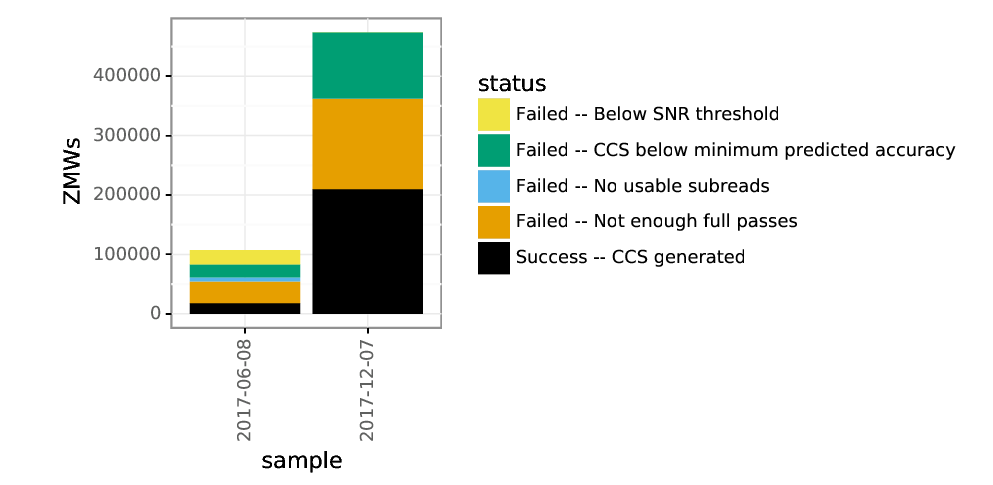

sample,status,number,fraction
2017-12-07,Success -- CCS generated,209930,0.4428
2017-12-07,Failed -- Not enough full passes,152429,0.3215
2017-12-07,Failed -- CCS below minimum predicted accuracy,110974,0.2341
2017-06-08,Failed -- Not enough full passes,36289,0.3371
2017-06-08,Failed -- Below SNR threshold,24052,0.2235
2017-06-08,Failed -- CCS below minimum predicted accuracy,22063,0.2050
2017-06-08,Success -- CCS generated,18063,0.1678
2017-06-08,Failed -- No usable subreads,6810,0.0633


In [6]:
ccsdir = os.path.join(pacbioresultsdir, 'ccs')
os.makedirs(ccsdir, exist_ok=True)

ccslist = []
for (seqrun, subreadsfile) in subreads.items():
    print("\nRunning `ccs` for sequencing run {0}".format(seqrun))
        
    reportfile = os.path.join(ccsdir, seqrun + '_report.csv')
    bamfile = os.path.join(ccsdir, seqrun + '_ccs.bam')
    logfile = os.path.join(ccsdir, seqrun + '_log.txt')
        
    if all(map(os.path.isfile, [reportfile, bamfile])):
        print("The `ccs` output already exists, so using that existing output.")
    else:  
        print("Running {0}...".format(
                subprocess.check_output(['ccs', '--version']).decode(
                'utf-8').strip()))
        ! ccs \
            --minLength 100 \
            --maxLength 5000 \
            --minPasses 3 \
            --minPredictedAccuracy 0.999 \
            --logFile {logfile} \
            --reportFile {reportfile} \
            --polish \
            --numThreads {ncpus} \
            {subreadsfile} \
            {bamfile}
        print("Completed `ccs` run.")
        
    ccslist.append(dms_tools2.pacbio.CCS(seqrun, bamfile, reportfile))

print("\nHere are statistics on the `ccs` results:")
zmw_plot = os.path.join(ccsdir, 'ZMW_plot.pdf')
showPDF(zmw_plot)

ccs_report = dms_tools2.pacbio.summarizeCCSreports(
                ccslist, 'zmw', zmw_plot)
display(HTML(ccs_report.query('fraction > 0.005').to_html(index=False)))

## Process CCS's
The PacBio sequencing was performed on PCR-amplified product.
This PCR product was amplified off the 10X barcoded material using semi-specific PCR with one end specifically annealing to flu transcripts.
We want to identify the CCS's that represent properly barcoded 10X material from influenza genes, and then call the barcodes and align the genes to the influenza genome.

### Features of barcoded CCSs
This [10X technical note](https://teichlab.github.io/scg_lib_structs/data/CG000108_AssayConfiguration_SC3v2.pdf) outlines the sequences appended by the v2 10X single-cell 3' kit used in these experiments. 
Specifically:
![./data/images/10Xschematic.png](./data/images/10Xschematic.png)

Zooming in on the 3' adaptor sequence, it is:
`CTACACGACGCTCTTCCGATCT-NNNNNNNNNNNNNNNN-NNNNNNNNNN-TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTVN` where the dash-delimited sequences are the read-1 priming site, the 16XN cell barcode, the 10XN UMI, the 30XT oligo-dT primer, followed by `V` (anything but `T`) and `N` (nominally, first nucleotide of upstream of mRNA polyA tail).

For the PCR to enrich the 10X product, Alistair used a 3' primer that anneals to this adaptor, namely:

In [7]:
primer3 = 'CTACACGACGCTCTTCCGATCT'
print("The length of the 3' primer is {0} nt".format(len(primer3)))

The length of the 3' primer is 22 nt


For the 5' primer, Alistair used a mix of primers that covered each of the 8 flu gene segments:

In [8]:
primer5_mix = {'PB2':'GCGAAAGCAGGTCAATTATATTCAATATGGAAAG',
               'PB1':'GCGAAAGCAGGCAAACCATTTG',
               'PA':'GCGAAAGCAGGTACTGATTCAAAATGG',
               'HA':'GCAAAAGCAGGGGAAAATAAAAACAACC',
               'NP':'GCAAAAGCAGGGTAGATAATCACTCAC',
               'NA':'GCGAAAGCAGGAGTTTAAATGAATCCAAAC',
               'M':'GCAAAAGCAGGTAGATATTGAAAGATGAGTC',
               'NS':'GCAAAAGCAGGGTGACAAAGACATAATG',
              }
print("The length of the 5' primer ranges from {0} to {1} nt".format(
        min(map(len, primer5_mix.values())), max(map(len, primer5_mix.values()))))

The length of the 5' primer ranges from 22 to 34 nt


### Flu mRNA alignment targets
We want to align the barcoded sequences to the flu mRNAs.
We will just align to the wildtype flu sequences, and then call the synonymous barcodes later.
The flu mRNA sequences are in [./data/flu_sequences/flu-wsn-mRNA.fasta](./data/flu_sequences/flu-wsn-mRNA.fasta).
We want to align to the sequence **interior** to the primer binding sites defined above: the region between the custom 5' primer and the polyA tail.
We therefore read in the mRNAs, and then trim each from the 5' termini to the end of the primer binding site, and then write these to a file to use as the alignment targets:

In [9]:
targets = []
for full_mRNA in Bio.SeqIO.parse('./data/flu_sequences/flu-wsn-mRNA.fasta', 'fasta'):
    full_mRNA_seq = str(full_mRNA.seq)
    primer = [p for p in primer5_mix.values() if full_mRNA_seq.count(p)]
    assert len(primer) == 1, "matched multiple primers in {0}".format(full_mRNA.name)
    targetseq = full_mRNA_seq[full_mRNA_seq.index(primer[0]) + len(primer[0]) : ]
    print("Aligning to a {0} nt region of {1}".format(len(targetseq), full_mRNA.name))
    targets.append((full_mRNA.name, targetseq))

aligndir = os.path.join(pacbioresultsdir, 'alignments')
os.makedirs(aligndir, exist_ok=True)
targetfile = os.path.join(aligndir, 'targets.fasta')
with open(targetfile, 'w') as f:
    f.write('\n'.join('>{0}\n{1}'.format(*tup) for tup in targets))

Aligning to a 2285 nt region of fluPB2
Aligning to a 2297 nt region of fluPB1
Aligning to a 2183 nt region of fluPA
Aligning to a 1725 nt region of fluHA
Aligning to a 1516 nt region of fluNP
Aligning to a 1357 nt region of fluNA
Aligning to a 973 nt region of fluM1
Aligning to a 285 nt region of fluM2
Aligning to a 839 nt region of fluNS1
Aligning to a 367 nt region of fluNS2


### Match and align barcoded CCSs
We use the function `dms_tools2.pacbio.matchAndAlignCCS` to go through the CCS's, find the ones that are "barcoded" (have the proper elements), and the align these barcoded genes.
All the results go into a pandas data frame.

Specifically, we look for CCS's that have:
  - Any 5' primer from Alistair's mix, trimmed a bit at the start since the first few nucleotides in the CCS might be off. We call this *termini5*.
  - The mRNA itself, which we call the *gene*.
  - The polyA tail, which is effectively a spacer between the *gene* and the *UMI* / *barcode*. We allow the polyA to be somewhat longer / shorter than the expected 30 `A`'s from 10X primer. We call this the *spacer*.
  - The 10-nucleotide UMI from the 10X primer, which we call *UMI*.
  - The 16-nucleotide cell barcode from the 10X primer, which we call *barcode*.
  - The 3' primer that Alistair used, which anneals in the read 1 primer binding site on the 10X primer. We call this *termini3*.
  
We don't require a match to the first 5 nt of each termini, as sometimes the ends of the CCS's can be "sloppy":

In [22]:
mapper = dms_tools2.minimap2.Mapper(targetfile,
        dms_tools2.minimap2.OPTIONS_VIRUS_W_DEL)
print("Performing alignments with minimap2 version {0}".format(mapper.version))

trim_ends = 5 # trim this many off each termini

df = dms_tools2.pacbio.matchAndAlignCCS(
        ccslist=ccslist,
        mapper=mapper,
        termini5='|'.join([s[trim_ends : ] for s in primer5_mix.values()]),
        gene='N+',
        spacer='A{25,35}',
        umi='N{10}',
        barcode='N{16}',
        termini3=dms_tools2.utils.reverseComplement(primer3)[ : trim_ends]
        )

Performing alignments with minimap2 version 2.10-r761


In [23]:
df.groupby(['gene_aligned', 'CCS_aligned', 'samplename']).size()

gene_aligned  CCS_aligned  samplename
False         False        2017-06-08     13608
                           2017-12-07    162724
              True         2017-06-08       912
                           2017-12-07     10876
True          True         2017-06-08      3543
                           2017-12-07     36330
dtype: int64